# Optical Pulse Propagation

In this notebook, the case of generalized nonlinear Schrödinger equations is studied, in the context of a ultra-short pulse of light, typically occuring in optical fibers.

The governing equation was derived starting from Maxwell's wave equation in 1D, and is a PDE known as a generalized nonlinear Schrödinger equation (GNLSE):

$$ \frac{\partial u}{\partial x} - \sum_{k=2}^{\infty} \alpha_k \frac{\partial^k u}{\partial t^k} = \left(i - \frac{\partial}{\partial t}\right) u \int_{-\infty}^{\infty} r(t') | u(t') |^2 \text{d} t' \\
r(t) = a \delta(t) + b \exp (ct) \sin (dt) \Theta(t) $$

This describes the variation of the complex envelope $u(x, t)$ of the pulse. This equation is the nondimenionalized version (done with soliton scalings). The delta-function component of the RHS integral is called the cubic Kerr nonlinearity. And the r(t) function is called the Raman Kernel.

The ($\alpha_{k}, a, b, c, d$) describe the polarization response and were determined empirically.

The data is obtained using the Callaham written code, itself using the code from J.C. Travers, M.H Frosz and J.M. Dudley (2009) which can be found [here](https://github.com/jtravs/SCGBookCode).

This code was written using some code from the ```Boundary_Layer``` Notebook, which used some original Callaham et al. turbulent boundary layer case code and custom written alternative code. With that code and the information in the paper and its supplementary information, the aim here was to try and reproduce the results from the paper.

In [1]:
import scipy.io as sio
import sys
import numpy as np
import pandas as pd
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import SparsePCA
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import os
import sklearn as sk

# adding Tools to the system path, and importing the modules
sys.path.insert(0, "../Tools/")
import plot_funcs as pf

In [2]:
# Creating the directory to save the plots
cur_dir = os.getcwd()
proj_dir = os.path.dirname(cur_dir)
plots_dir = os.path.join(proj_dir, "Plots/Opt_Pul")
os.makedirs(plots_dir, exist_ok=True)

## 1. Load the data

From the governing , and the paper, the terms needed are:
- $\frac{\partial u}{\partial x}$, u_x
- Multiple order time derivatives of u, which go up to 10 in the data, and 6 in the paper.
- u, the propagation speed

As discussed in the supplementary information and from the ```gnlse_terms.m``` code, the Raman kernel and cubic Kerr nonlinearity terms are obtained as:
- R, is the going to be be the Raman term without the cubic Kerr nonlinearity.
- Kerr, or $|u|^{2}u$, will be the cubic Kerr nonlinearity.


In [3]:
data = sio.loadmat("../Data/gnlse_nondim.mat")

# Extract the variables needed:
u = data["u"]
u_x = data["ux"]
u_t = data["du_dt"][0, 1]
u_tt = data["du_dt"][0, 2]
u_3t = data["du_dt"][0, 3]
u_4t = data["du_dt"][0, 4]
u_5t = data["du_dt"][0, 5]
u_6t = data["du_dt"][0, 6]

R = data["raman"]
u2u = data["kerr"]

In [4]:
# print shapes
print(u.shape)
print(u_x.shape)
print(u_t.shape)
print(u_tt.shape)
print(u_3t.shape)
print(u_4t.shape)
print(u_5t.shape)
print(u_6t.shape)
print(R.shape)
print(u2u.shape)

(1000, 8192)
(1000, 8192)
(1000, 8192)
(1000, 8192)
(1000, 8192)
(1000, 8192)
(1000, 8192)
(1000, 8192)
(1000, 8192)
(1000, 8192)


In [5]:
# Visualise the terms in space
x = data["x"]
t = data["t"]

From the test_Dudley.m code, the visualisation obtained in the callaham paper is done by putting the variables on a log-scale. Following that matlab code, the following visualisation is obtained:

/var/folders/kt/m5clbvx50n37tx6gpnr84gd80000gn/T/ipykernel_1086/2322493486.py:3: RuntimeWarning: divide by zero encountered in log10
  field = 10 * np.log10(np.abs(u) ** 2)


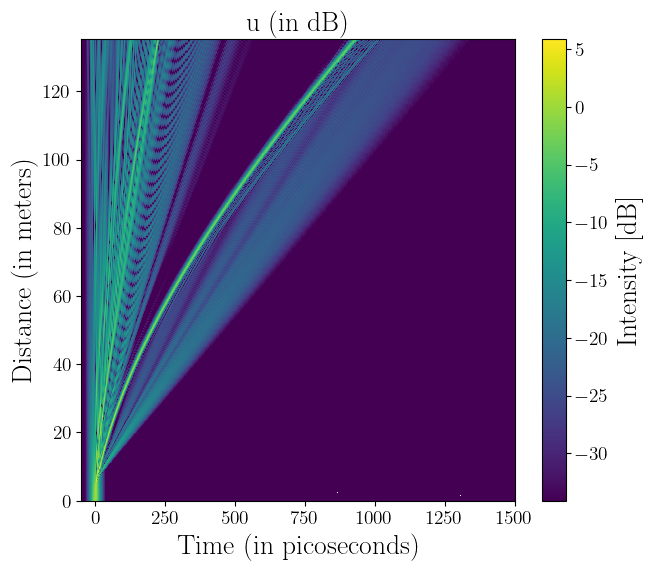

In [6]:
# Plot one of the terms: u
fig = plt.figure(figsize=(7, 6))
field = 10 * np.log10(np.abs(u) ** 2)
max_u = np.max(field)
plt.pcolormesh(t, x, field, vmin=max_u - 40, vmax=max_u)
plt.xlim([-50, 1500])
cbar = plt.colorbar()
cbar.set_label("Intensity [dB]")
plt.xlabel("Time (in picoseconds)")
plt.ylabel("Distance (in meters)")
plt.title("u (in dB)")

# Save the plot
cur_dir = os.getcwd()
proj_dir = os.path.dirname(cur_dir)
plots_dir = os.path.join(proj_dir, "Plots")
os.makedirs(plots_dir, exist_ok=True)

plot_dir = os.path.join(plots_dir, "Opt_Pul/u.png")
plt.savefig(plot_dir)

plt.show()

## 2. Getting the features (Equation Space representation)

In [7]:
# Define the labels
labels = [
    r"$u_{t}^{(2)}$",
    r"$u_{t}^{(3)}$",
    r"$u_{t}^{(4)}$",
    r"$u_{t}^{(5)}$",
    r"$u_{t}^{(6)}$",
    r"$|u|^{2}$",
    r"$R$",
    r"$u_{x}$",
]

In [8]:
# Get the terms in an array
# Because it is of little interest, remove all points for t < 200
idx = np.where(t > -200)[1][0]

u_x_sub = u_x[:, idx:]
u_tt_sub = u_tt[:, idx:]
u_3t_sub = u_3t[:, idx:]
u_4t_sub = u_4t[:, idx:]
u_5t_sub = u_5t[:, idx:]
u_6t_sub = u_6t[:, idx:]
R_sub = R[:, idx:]
u2u_sub = u2u[:, idx:]

# Flatten the terms
u_x_sub = u_x_sub.flatten()
u_tt_sub = u_tt_sub.flatten()
u_3t_sub = u_3t_sub.flatten()
u_4t_sub = u_4t_sub.flatten()
u_5t_sub = u_5t_sub.flatten()
u_6t_sub = u_6t_sub.flatten()
R_sub = R_sub.flatten()
u2u_sub = u2u_sub.flatten()

In [9]:
# Create the array according to Fig 9 in the supplementary informations
features = np.array(
    np.array(
        [u_tt_sub, u_3t_sub, u_4t_sub, u_5t_sub, u_6t_sub, u2u_sub, R_sub, u_x_sub]
    ).T
)
nfeatures = features.shape[1]

# Because complex values are not supported in the GMM,
# we will use the real part of the features for now
features = np.real(features)

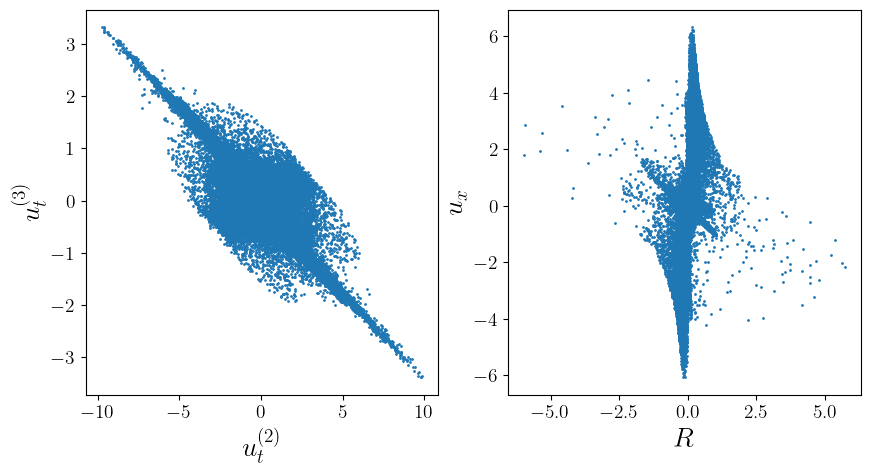

In [10]:
# Visualise some of the features
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Plot the features
ax[0].scatter(features[:, 0], features[:, 1], s=1)
ax[0].set_xlabel(labels[0])
ax[0].set_ylabel(labels[1])

ax[1].scatter(features[:, 6], features[:, 7], s=1)
ax[1].set_xlabel(labels[6])
ax[1].set_ylabel(labels[7])

# Save the plot
cur_dir = os.getcwd()
proj_dir = os.path.dirname(cur_dir)
plots_dir = os.path.join(proj_dir, "Plots")
os.makedirs(plots_dir, exist_ok=True)

plot_dir = os.path.join(plots_dir, "Opt_Pul/features.png")
plt.savefig(plot_dir)

plt.show()

## 3. GMM clustering

Again, the data is clustered using GMM, with 6 clusters, with the model trained only on 15% of the data, which again is due to the very high resolution of the data.

In [11]:
# Set the seed
seed = 75016
np.random.seed(seed)

# Fit the model on 50% of the data
frac = 0.15
features_train, _ = sk.model_selection.train_test_split(
    features, train_size=frac, random_state=seed
)

# And with 6 clusters
n_clusters = 6
model = GaussianMixture(n_components=n_clusters, random_state=seed)
model.fit(features_train)

GaussianMixture(n_components=6, random_state=75016)

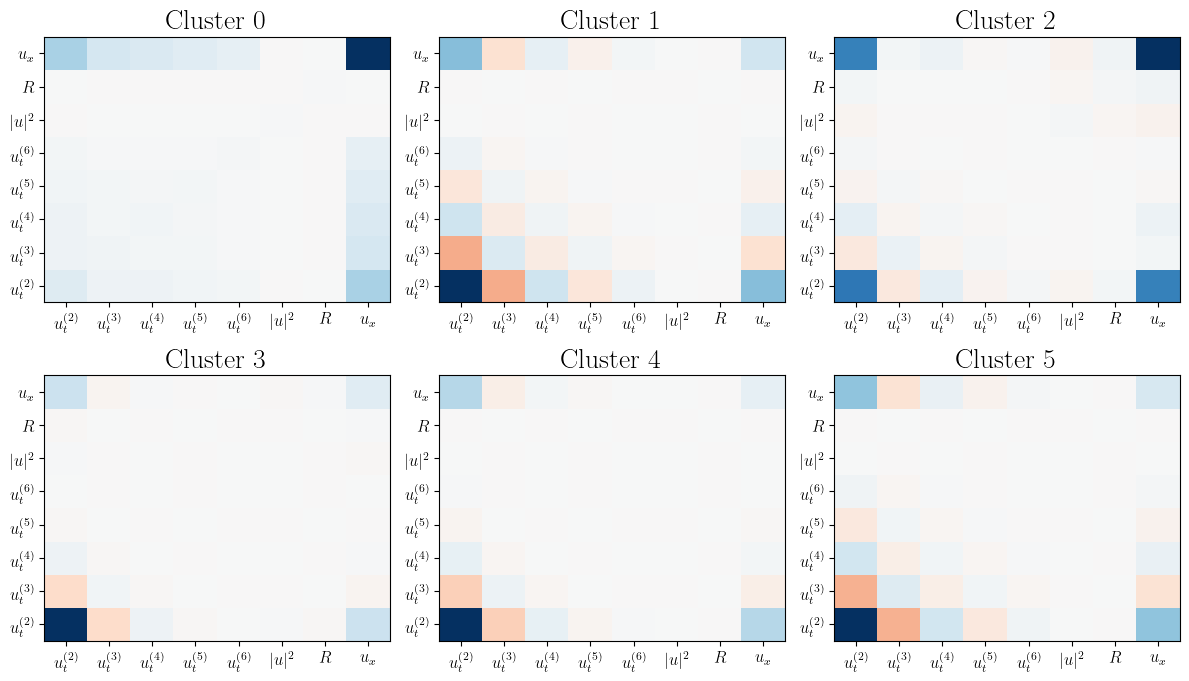

In [12]:
# Plot the covariance matrices of each cluster
pf.plot_cov_mat(
    model, nfeatures, n_clusters, labels, "GMM", f"Opt_Pul/cov_mat_{n_clusters}.png"
)

Thus, there is a clear pattern in the dominant balances of each cluster, with progressively higher-order derivatives being important. But with the second time derivative and x-derivative of u directions always having high variance.

In [13]:
# Predict the clusters for the entire dataset
cluster_idx = model.predict(features)

In [14]:
# Define a clustermap by reshaping the cluster_idx
nx = len(x.flatten())
nt = len(t[0, idx:].flatten())

clustermap = cluster_idx.reshape(nx, nt)

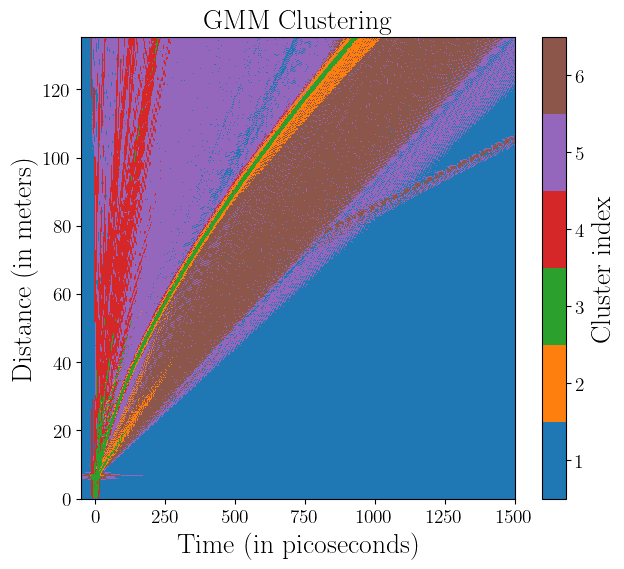

In [15]:
# Plot the clustermap in the time-distance domain
t_sub = t[:, idx:]

pf.plot_clustering_optics(
    clustermap, x, t_sub, n_clusters, f"Opt_Pul/clustermap_{n_clusters}.png"
)

## 3. Sparse PCA identification of the active terms

Using the alternative method written in the Boundary Layer case notebook, the residuals for each regularization value $\alpha$ is calculated as the $l_{2}$-norm of the neglected terms across all clusters (see [Supplementary Information](https://static-content.springer.com/esm/art%3A10.1038%2Fs41467-021-21331-z/MediaObjects/41467_2021_21331_MOESM1_ESM.pdf))

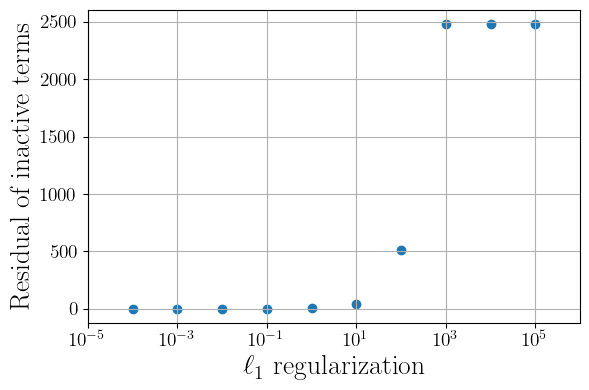

In [16]:
# Compute SPCA residuals to choose the optimal alpha

alphas = [1e-4, 1e-3, 1e-2, 0.1, 1, 10, 100, 1e3, 1e4, 1e5]
err = np.zeros([len(alphas)])


def spca_err(alpha, cluster_idx, features, nc):
    err_ = 0

    for i in range(nc):
        # Identify points in the field corresponding to each cluster
        feature_idx = np.where(cluster_idx == i)[0]
        cluster_features = features[feature_idx, :]

        # Conduct Sparse PCA
        spca = SparsePCA(n_components=1, alpha=alpha)
        spca.fit(cluster_features)

        # Identify active and inactive terms
        inactive_terms = np.where(spca.components_[0] == 0)[0]

        err_ += np.sqrt(np.sum((cluster_features[:, inactive_terms].ravel()) ** 2))

    return err_


from joblib import Parallel, delayed

err = Parallel(n_jobs=4)(
    delayed(spca_err)(alpha, cluster_idx, features, n_clusters) for alpha in alphas
)

pf.plot_spca_residuals(alphas, err, f"Opt_Pul/spca_residuals_{n_clusters}.png")

Here, the alpha value that was found to result in the most similar dominant balances was found to be 10.

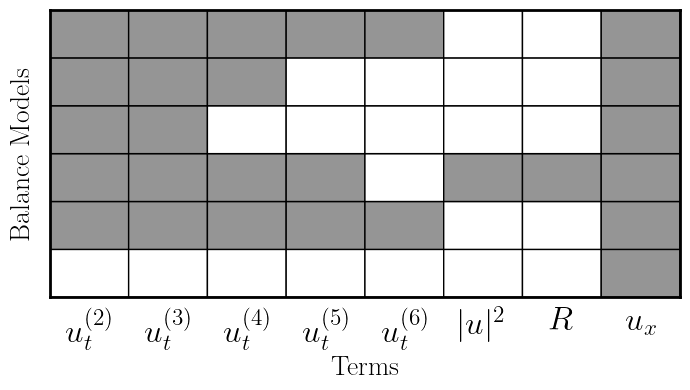

In [17]:
# Set the alpha regularization term to 10
alpha = 10

# Initialize the sparse PCA model
spca_model = np.zeros((n_clusters, nfeatures))

for i in range(n_clusters):
    feature_idx = np.where(cluster_idx == i)[0]
    cluster_features = features[feature_idx, :]

    spca = SparsePCA(n_components=1, alpha=alpha, random_state=seed)
    spca.fit(cluster_features)

    active_terms = np.where(spca.components_[0] != 0)[0]
    if len(active_terms) > 0:
        spca_model[i, active_terms] = 1  # Set the active terms to 1

pf.plot_balance_models(
    spca_model, labels, False, f"Opt_Pul/active_terms_{n_clusters}_{alpha}.png"
)

## 4. Get Unique Dominant Balance Models

Again, using the alternative code, which uses `pandas`' `.groupby()` method, the unique balance models are obtained


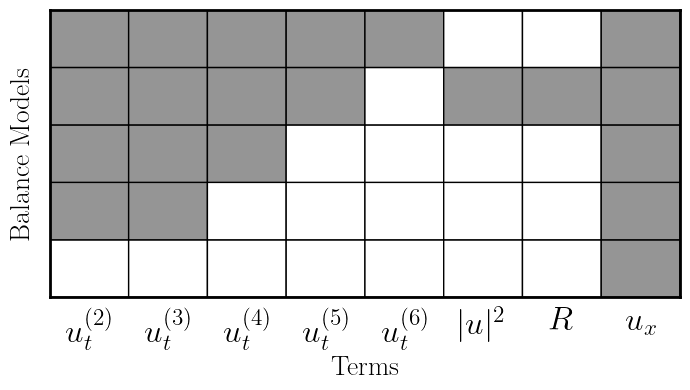

In [18]:
# Convert the spca_model array to a dataframe
spca_temp = pd.DataFrame(spca_model.copy())

# Group the balance models by the values of all columns
grouped_models = spca_temp.groupby(np.arange(nfeatures).tolist())
grouped_models = grouped_models.groups.items()

# Combine balance models that have identical active terms
# For each balance model, the spca models that have the same active terms
# are given the same index
balance_models = pd.DataFrame(np.zeros((len(grouped_models), nfeatures)))

model_idx = np.zeros(len(spca_model), dtype=int)
for i, model in enumerate(grouped_models):
    idx = model[1].to_list()
    model_idx[idx] = i
    balance_models.loc[i] = spca_temp.loc[idx[0]].to_numpy()

# Convert the balance models to a numpy array
balance_models = balance_models.drop_duplicates(keep="first")
balance_models = balance_models.to_numpy()
nmodels = balance_models.shape[0]

# Plot a grid of the active terms
pf.plot_balance_models(
    balance_models,
    labels,
    False,
    f"Opt_Pul/final_active_terms_{n_clusters}_{alpha}.png",
)

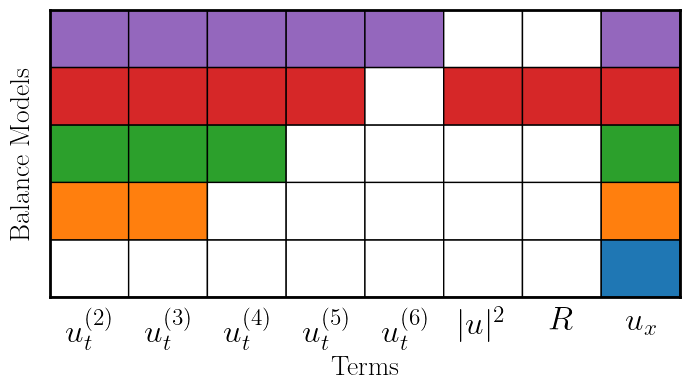

In [19]:
# Plot the balance models in a grid

pf.plot_balance_models(
    balance_models, labels, True, f"Opt_Pul/balance_models_{n_clusters}_{alpha}.png"
)

In [20]:
# Assign the new cluster indices
balance_idx = np.array([model_idx[i] for i in cluster_idx])

# Define a new clustermap
balance_clustermap = balance_idx.reshape(nx, nt)

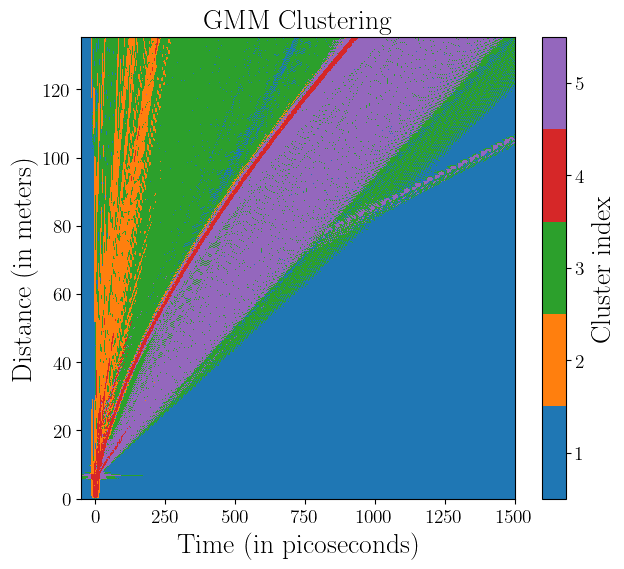

In [22]:
# Plot the final balance models in the time-distance domain
pf.plot_clustering_optics(
    balance_clustermap,
    x,
    t_sub,
    nmodels,
    f"Opt_Pul/balance_clustermap_{n_clusters}_{alpha}.png",
)

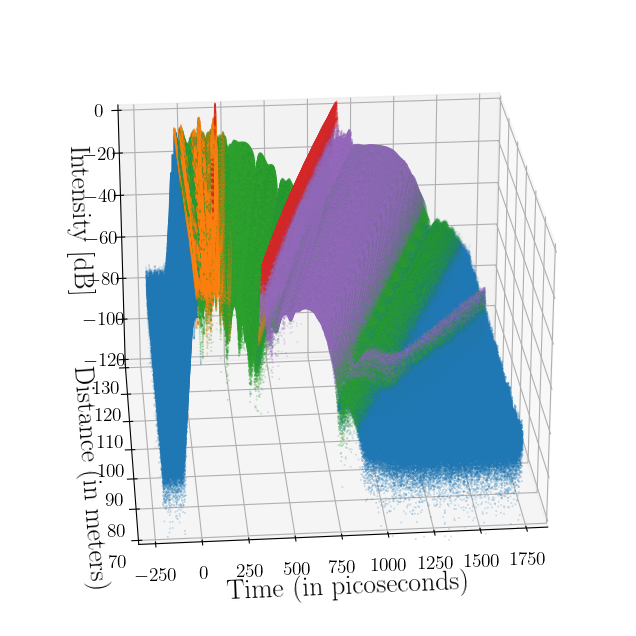

In [23]:
# Plot the 3D plot of the balance models, with the Intensity field as the height
pf.plot_optical_pulse_3D(
    x,
    t,
    field,
    balance_clustermap,
    f"Opt_Pul/balance_models_3D_{n_clusters}_{alpha}.png",
)

Overall, similar dominant balances were found except for the strongest soliton identified balance (red), which was found in the paper to be the only region where the instantaneous nonlinear response was identified, which does have the Raman term active. But it is still the only identified balance with just the nonlinearity term active.